# Импортирование библиотек

In [47]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from functools import reduce

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor


# from mlxtend.regressor import StackingCVRegressor

from sklearn.linear_model import ElasticNet  # мета-модель

from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Загрузка данных

In [48]:
train_xlsx = pd.read_excel("data/train.xlsx").to_csv("csvs/train.csv", sep=",", index = False)
test_xlsx = pd.read_excel("data/test.xlsx").to_csv("csvs/test.csv", sep=",", index = False)
gruz = pd.read_excel("data/Грузоперевозки.xlsx").to_csv("csvs/cargo.csv", sep=",", index = False)
rynok_data = pd.read_excel("data/Данные рынка стройматериалов.xlsx").to_csv("csvs/market_data.csv", sep=",", index = False)
lme = pd.read_excel("data/Индекс LME.xlsx").to_csv("csvs/index_LME.csv",sep=",", index = False)
macro_pok = pd.read_excel("data/Макропоказатели.xlsx").to_csv("csvs/macro.csv", sep=",", index = False)
pok_ryn = pd.read_excel("data/Показатели рынка металла.xlsx").to_csv("csvs/metal_market.csv", sep=",", index = False)
topl = pd.read_excel("data/Топливо.xlsx").to_csv("csvs/fuel.csv", sep=",", index = False)
syrye_price = pd.read_excel("data/Цены на сырье.xlsx").to_csv("csvs/material_price.csv", sep=",", index = False)

train = pd.read_csv("csvs/train.csv")
test = pd.read_csv("csvs/test.csv")

train = pd.concat([train, test])

cargo = pd.read_csv("csvs/cargo.csv")
market_data = pd.read_csv("csvs/market_data.csv")
index_LME = pd.read_csv("csvs/index_LME.csv")
macro = pd.read_csv("csvs/macro.csv")
metal_market = pd.read_csv("csvs/metal_market.csv")
fuel = pd.read_csv("csvs/fuel.csv")
material_price = pd.read_csv("csvs/material_price.csv")

Привожу колонку с ценой к флоату и переименновываю

In [49]:
index_LME['цена'] = pd.to_numeric(index_LME['цена'], errors='coerce')
index_LME['цена'] = index_LME['цена'].dropna().astype(float)
index_LME.rename(columns={'дата': 'dt'}, inplace=True) 

Создаю список со всеми данными

In [50]:
add_data = [
    train,
    cargo,
    market_data,
    index_LME,
    macro,
    metal_market,
    fuel,
    material_price
]

Вычисляем временные отрывки

In [51]:
for i, data in enumerate(add_data):
    data['dt'] = pd.to_datetime(data['dt'], format='%Y-%m-%d')
    add_data[i] = data.set_index('dt').resample('W-MON').mean().reset_index()
    print(f"{data['dt'].min()} - {data['dt'].max()}")
    
data['dt'] = data['dt'].dt.date

2015-01-05 00:00:00 - 2023-03-13 00:00:00
2017-09-06 00:00:00 - 2023-06-14 00:00:00
2021-04-30 00:00:00 - 2023-04-30 00:00:00
2021-02-12 00:00:00 - 2023-03-27 00:00:00
2016-01-31 00:00:00 - 2023-06-16 00:00:00
2016-03-31 00:00:00 - 2023-03-31 00:00:00
2017-02-28 00:00:00 - 2023-05-31 00:00:00
2015-02-09 00:00:00 - 2023-03-13 00:00:00


Получаем временной отрывок, в котором есть все колонки

In [52]:
min_date = max(data['dt'].min() for data in add_data)
max_date = min(data['dt'].max() for data in add_data)
print(min_date, '  ------------  ', max_date)

2021-05-03 00:00:00   ------------   2023-03-13 00:00:00


сортируем по дате

In [53]:
for data in add_data:
    data = data[(data['dt'] >= min_date) & (data['dt'] <= max_date)].reset_index(drop=True)
train = train.set_index('dt')

Добавляем колонку с месяцем и днем недели

In [54]:
train['month'] = train.index.month
train['day_of_week'] = train.index.dayofweek

График распределения цены

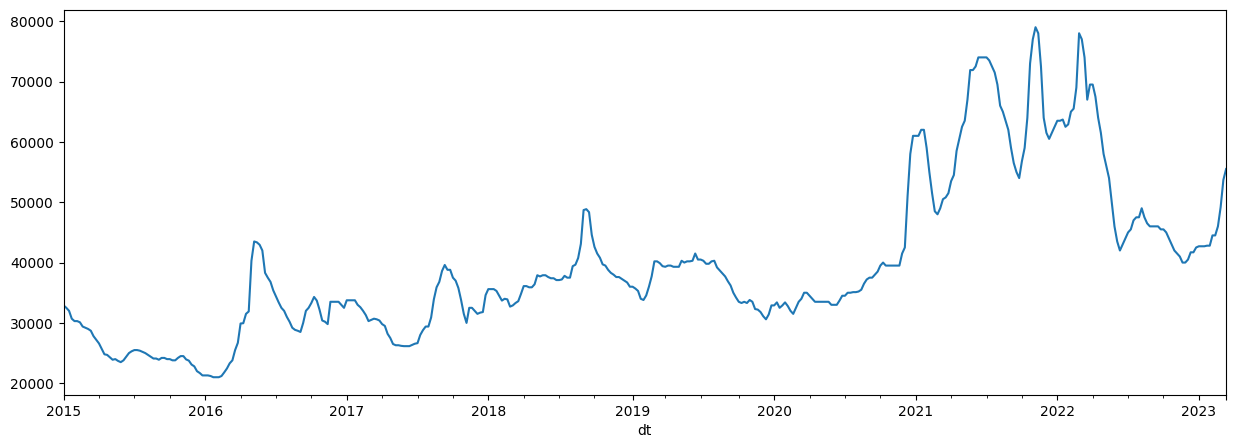

In [55]:
train['Цена на арматуру'].plot(figsize=(15, 5))
plt.show()

In [56]:
decompose = seasonal_decompose(train['Цена на арматуру'], model='multiplicative',period=12)

График сезонности, тренда и неконтроллируемой ошибки

<Axes: title={'center': 'Остаток'}, xlabel='dt'>

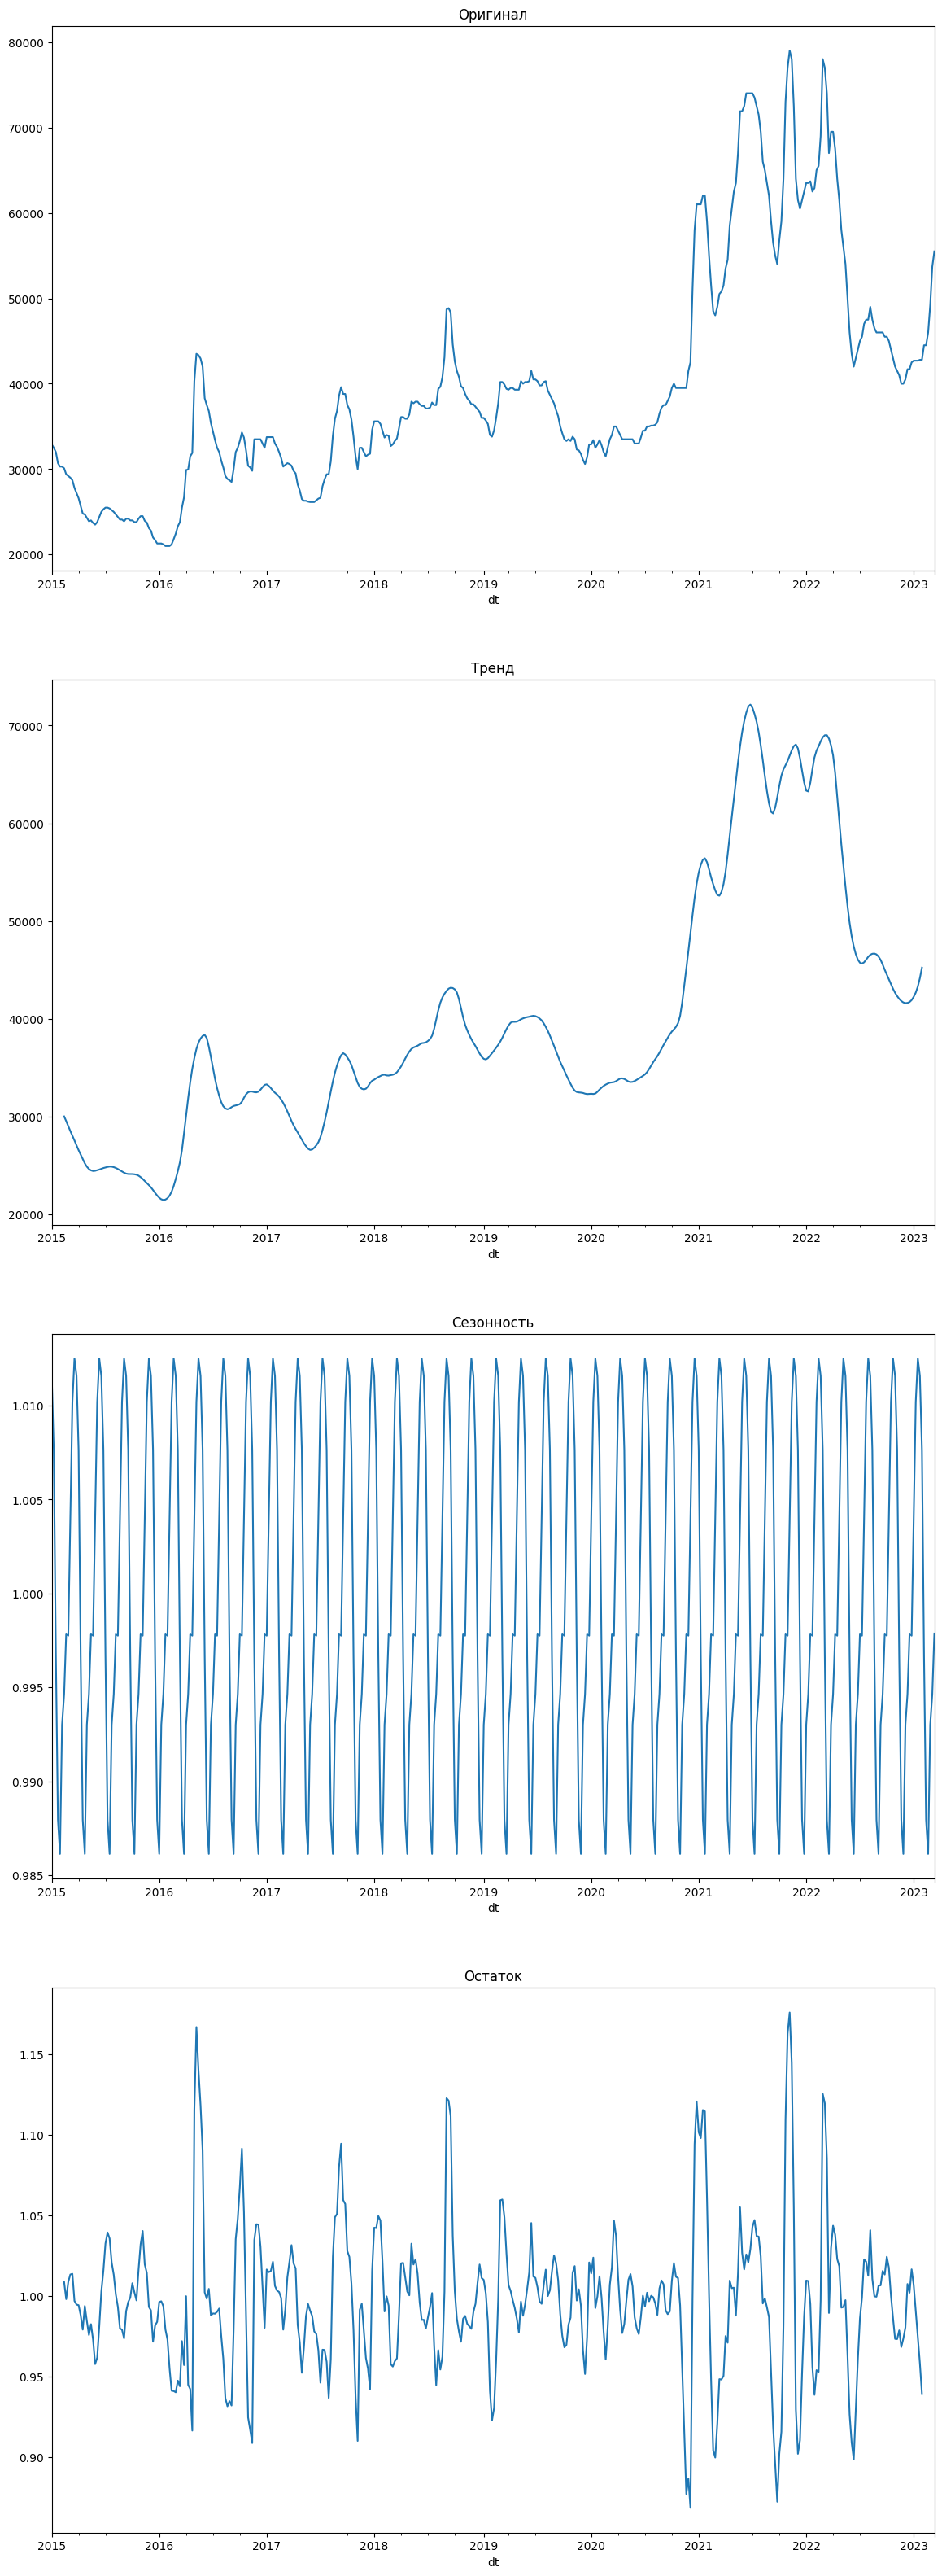

In [57]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))


ax[0].set_title('Оригинал')
ax[1].set_title('Тренд')
ax[2].set_title('Сезонность')
ax[3].set_title('Остаток')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3])

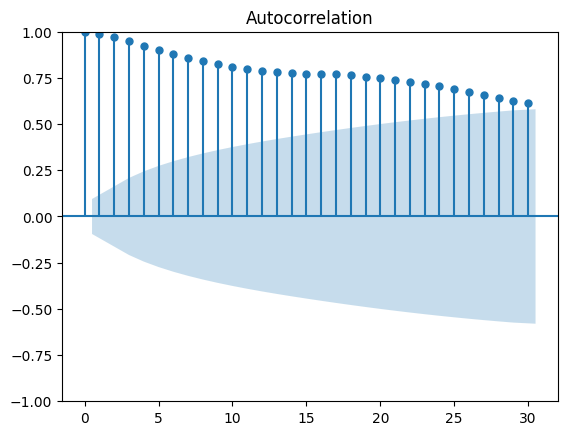

In [58]:
plot_acf(train['Цена на арматуру'], lags=30)  
plt.show()


In [59]:

df_merged = reduce(lambda left, right: pd.merge(left, right, on='dt', how='inner'), add_data)  # заполнить маркет дата на 4 недели чтобы без выебонов
df_merged.set_index('dt', inplace=True)
df_merged.index = df_merged.index.date
df_merged.index = pd.to_datetime(df_merged.index)
df_merged['month'] = train['month']
df_merged['day_of_week'] = train['day_of_week']

df_merged.to_csv('df_merged1.csv')
df_merged.head(12)

Цена на арматуру  Индекс стоимости грузоперевозок  \
2021-05-03           62500.0                           1060.0   
2021-05-10           63500.0                           1094.0   
2021-05-17           67000.0                           1073.0   
2021-05-24           71900.0                           1078.0   
2021-05-31           71900.0                           1096.0   
2021-06-07           72500.0                           1128.0   
2021-06-14           74000.0                           1120.0   
2021-06-21           74000.0                           1116.0   
2021-06-28           74000.0                           1134.0   
2021-07-05           74000.0                           1175.0   
2021-07-12           73500.0                           1182.0   
2021-07-19           72500.0                           1170.0   

            Импорт цемента ЖД  Экспорт цемента ЖД  Отгрузка цемента хоппер ЖД  \
2021-05-03             40.751              27.530                     987.540   
2021-05-10                NaN                 NaN                         NaN   
2021-05-17                NaN                 NaN                         NaN   
2021-05-24                NaN                 NaN                         NaN   
2021-05-31             69.979              43.423                    1071.832   
2021-06-07                NaN                 NaN                         NaN   
2021-06-14                NaN                 NaN                         NaN   
2021-06-21                NaN                 NaN                         NaN   
2021-06-28                NaN                 NaN                         NaN   
2021-07-05            105.525              58.226                    1495.351   
2021-07-12                NaN                 NaN                         NaN   
2021-07-19                NaN                 NaN                         NaN   

            Отгрузка цемента остальные ЖД  Производство цемента  \
2021-05-03                        201.757                2.3891   
2021-05-10                            NaN                   NaN   
2021-05-17                            NaN                   NaN   
2021-05-24                            NaN                   NaN   
2021-05-31                        256.733                2.7115   
2021-06-07                            NaN                   NaN   
2021-06-14                            NaN                   NaN   
2021-06-21                            NaN                   NaN   
2021-06-28                            NaN                   NaN   
2021-07-05                        446.953                3.8468   
2021-07-12                            NaN                   NaN   
2021-07-19                            NaN                   NaN   

            Импорт цемента  Экспорт цемента  Потребление цемента  ...  \
2021-05-03       52.331737         31.49115             2.290941  ...   
2021-05-10             NaN              NaN                  NaN  ...   
2021-05-17             NaN              NaN                  NaN  ...   
2021-05-24             NaN              NaN                  NaN  ...   
2021-05-31       79.639340         50.16415             2.670775  ...   
2021-06-07             NaN              NaN                  NaN  ...   
2021-06-14             NaN              NaN                  NaN  ...   
2021-06-21             NaN              NaN                  NaN  ...   
2021-06-28             NaN              NaN                  NaN  ...   
2021-07-05      125.590100         64.99075             3.984199  ...   
2021-07-12             NaN              NaN                  NaN  ...   
2021-07-19             NaN              NaN                  NaN  ...   

            ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС  \
2021-05-03                                            12736.0                           
2021-05-10                                            12736.0                           
2021-05-17             

In [60]:
df_cleaned = df_merged.dropna(axis=1, how='all')
df_cleaned.interpolate(method='linear', inplace=True)

print(df_cleaned.isnull().mean()*100)

Цена на арматуру                                                             0.0
Индекс стоимости грузоперевозок                                              0.0
Импорт цемента ЖД                                                            0.0
Экспорт цемента ЖД                                                           0.0
Отгрузка цемента хоппер ЖД                                                   0.0
                                                                            ... 
ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС    0.0
ЖРС_Украинский концентрат Fe 65-68%,  DAP граница Украины с Европой,  $/т    0.0
ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой,  $/т        0.0
month                                                                        0.0
day_of_week                                                                  0.0
Length: 162, dtype: float64


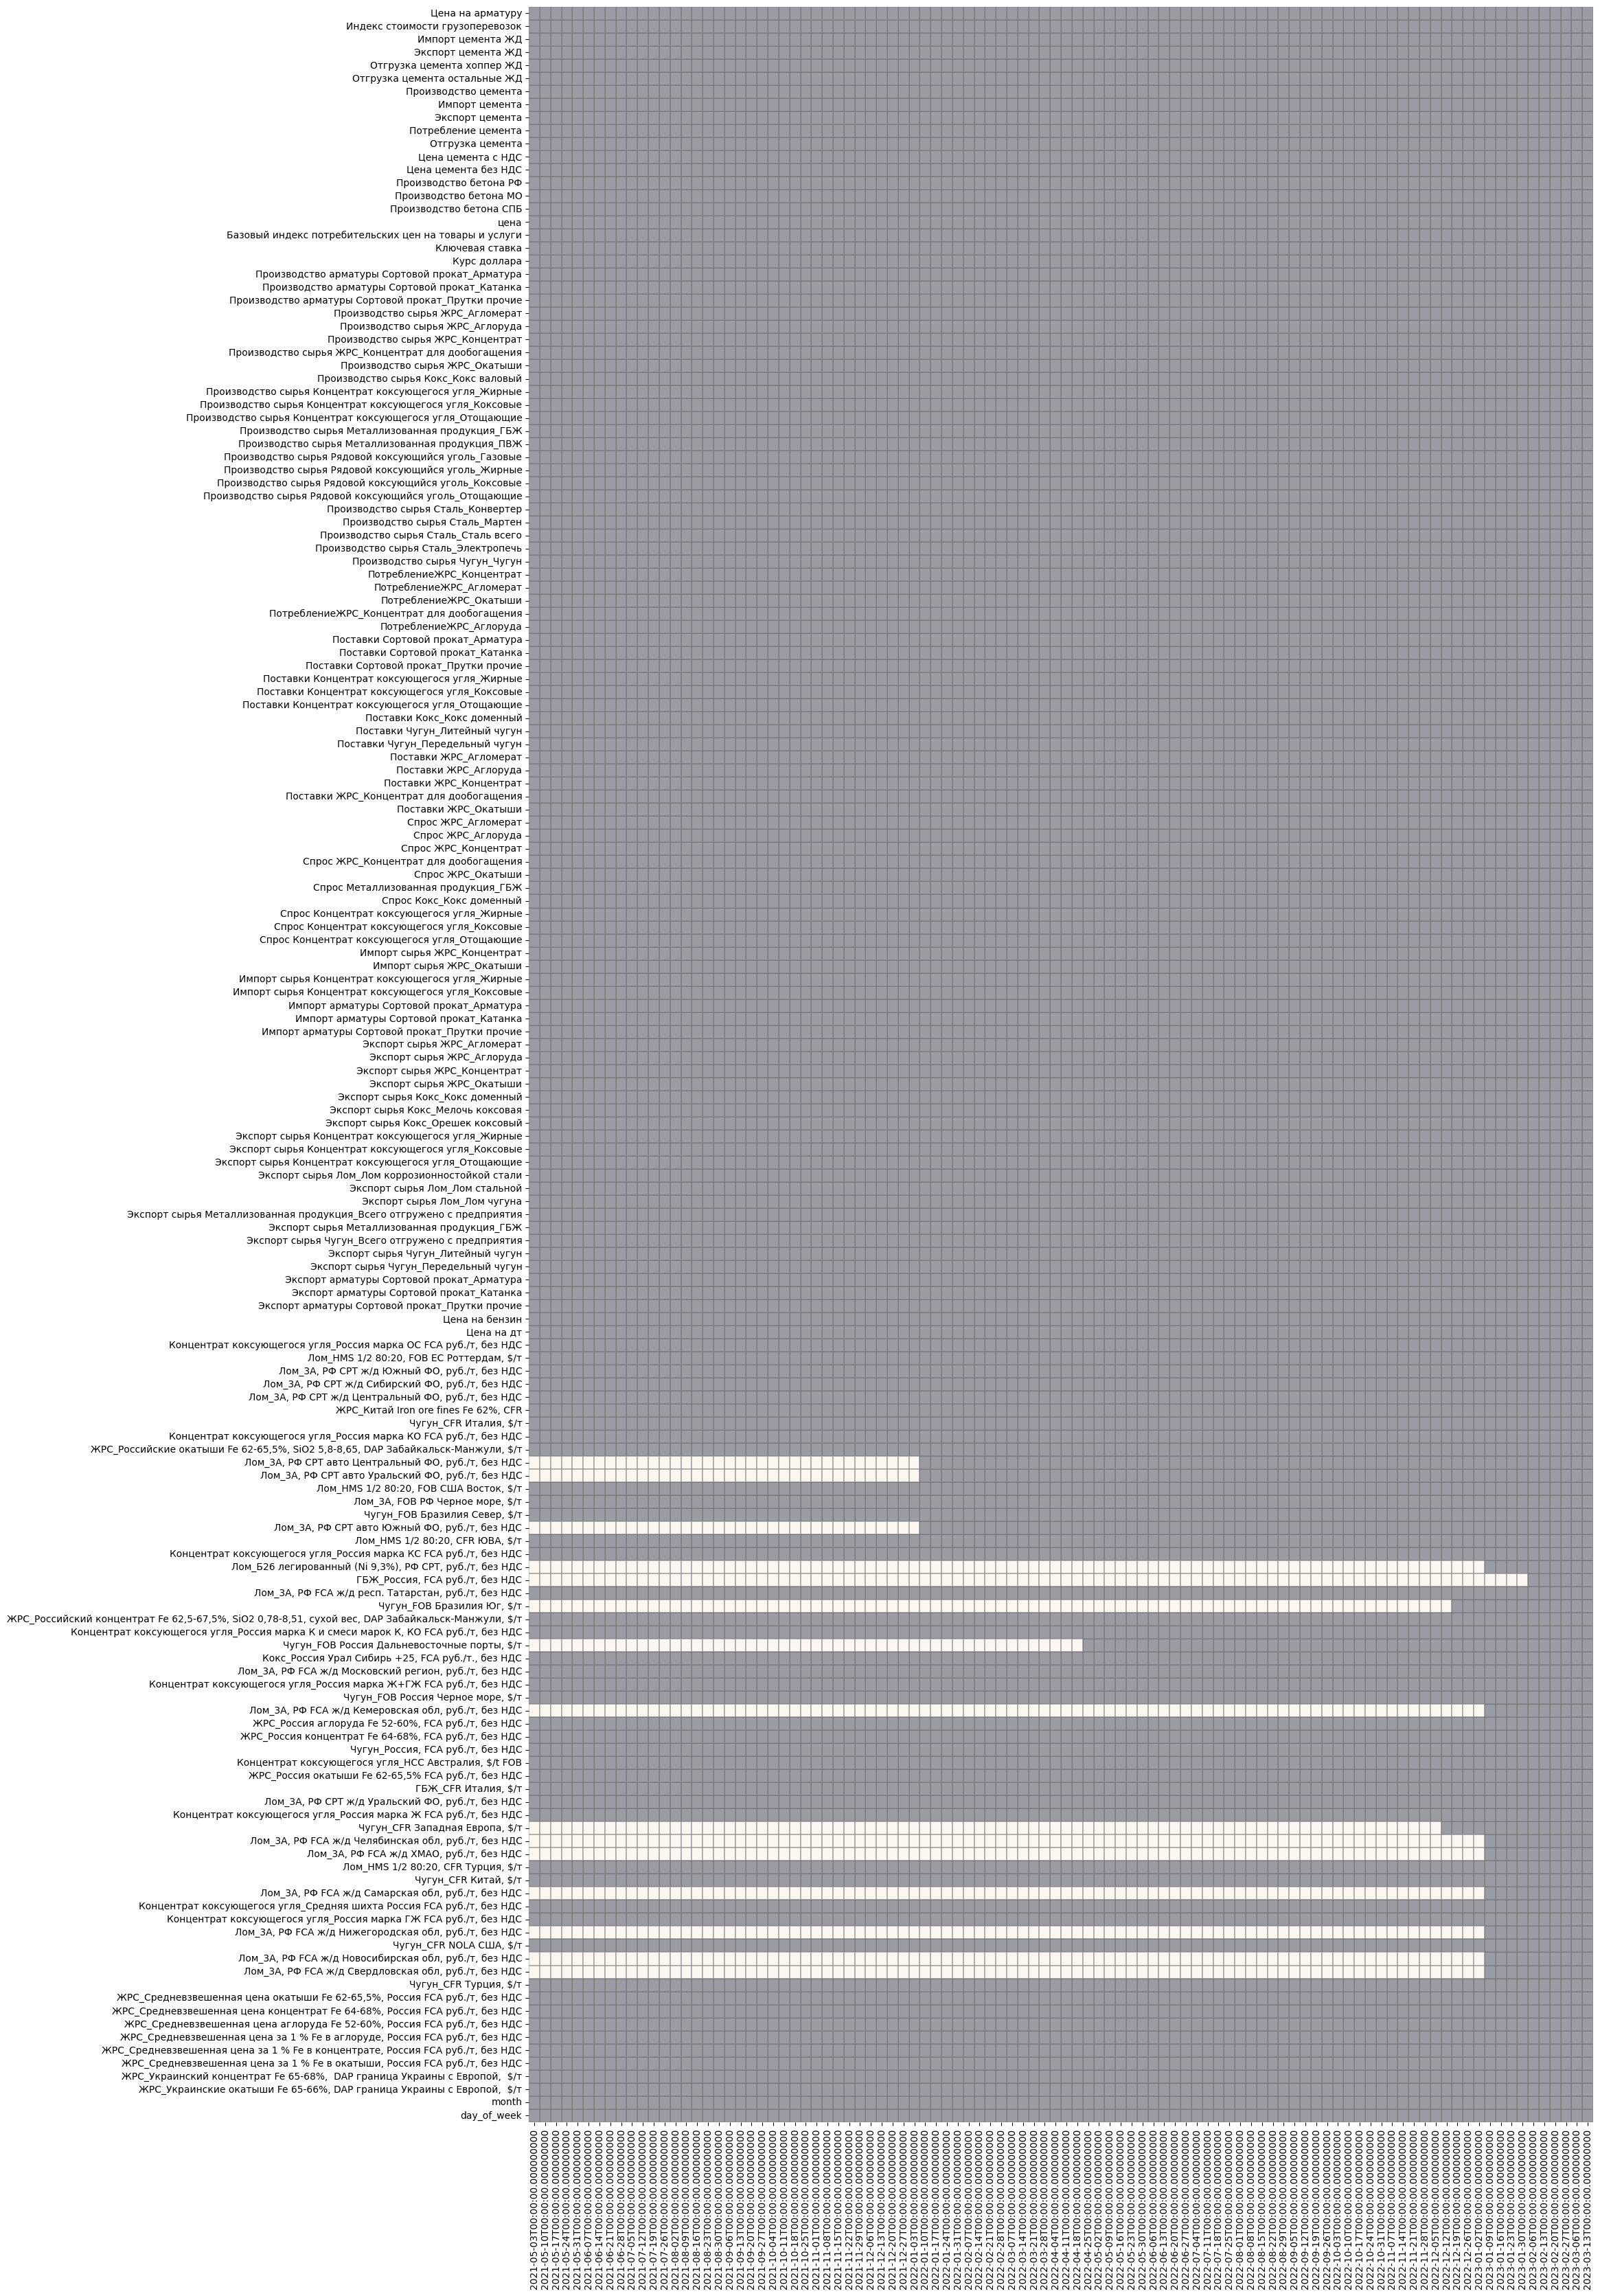

In [61]:
plt.figure(figsize=(20, 40)) 
sns.heatmap(df_cleaned.T.isnull(), cbar=False, linewidths=0.1, linecolor='gray', alpha=0.4)
plt.show()

In [62]:
print(df_cleaned.shape)
df_cleaned.dropna(axis=1, inplace=True)
print(df_cleaned.shape)

(98, 162)
(98, 147)


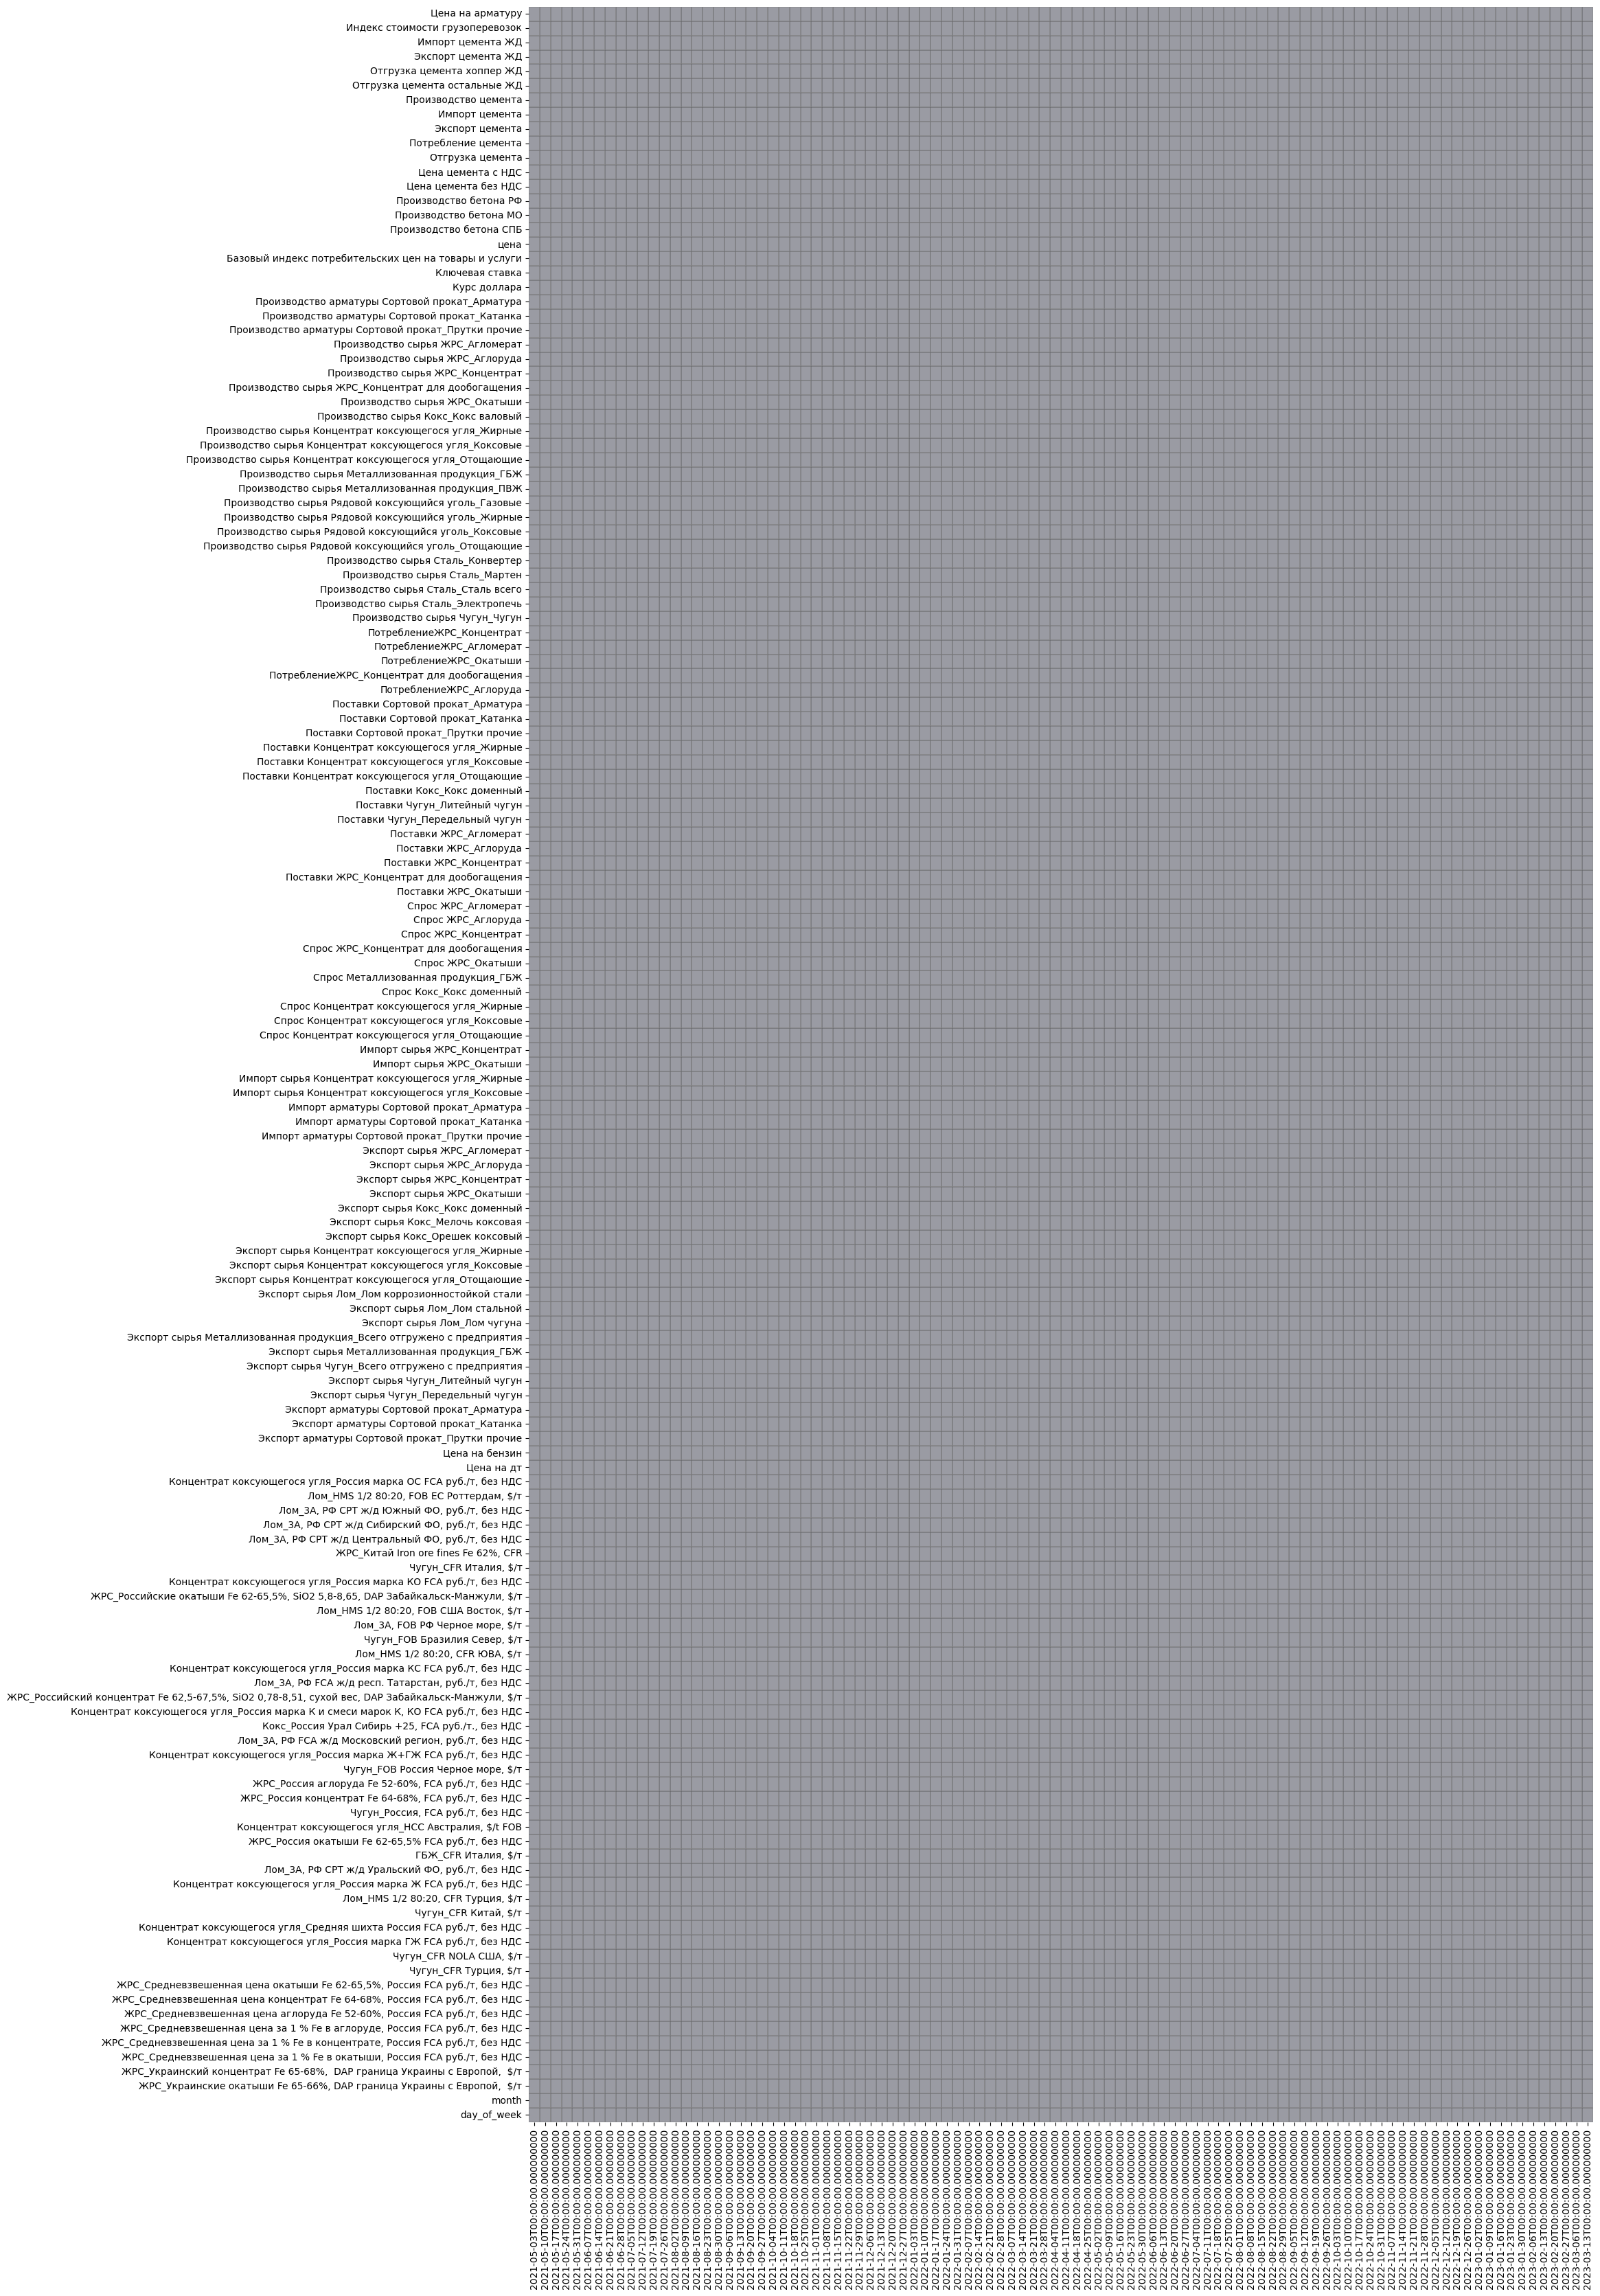

In [63]:
plt.figure(figsize=(20, 40)) 
sns.heatmap(df_cleaned.T.isnull(), cbar=False, linewidths=0.1, linecolor='gray', alpha=0.4)
plt.show()

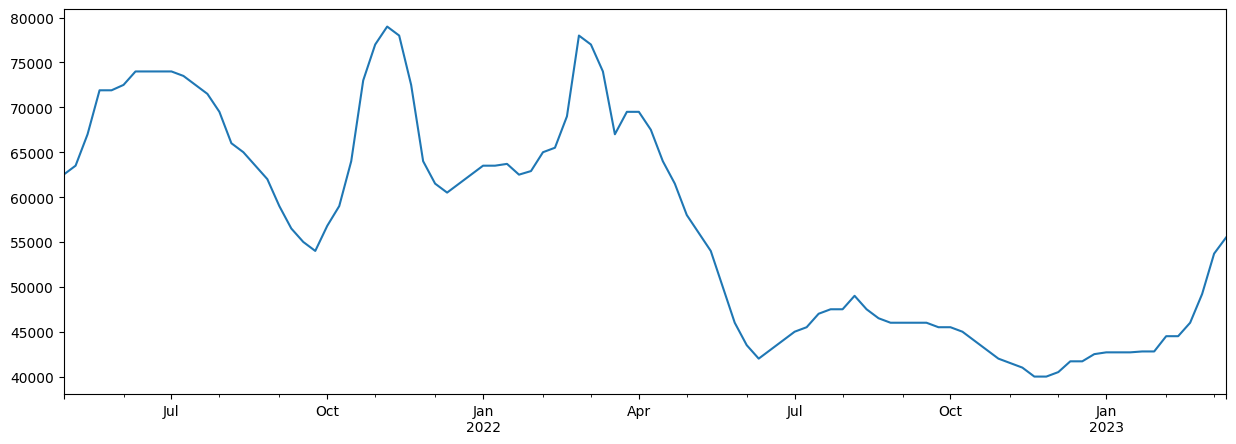

In [64]:
df_cleaned['Цена на арматуру'].plot(figsize=(15, 5))
plt.show()

In [65]:
# def number_encode_features(init_df):
#     result = init_df.copy()
#     encoders = {}
#     for column in result.columns:
#         if result.dtypes[column] == object:
#             encoders[column] = LabelEncoder()
#             result[column] = encoders[column].fit_transform(result[column])      # нужна она блять или нет
#     return result, column

# encoded_df, encoders = number_encode_features(df_cleaned)
# corr_mat = encoded_df.corr()

# plt.figure(figsize=[70, 70])
# sns.heatmap(corr_mat, annot=True)
# plt.show()

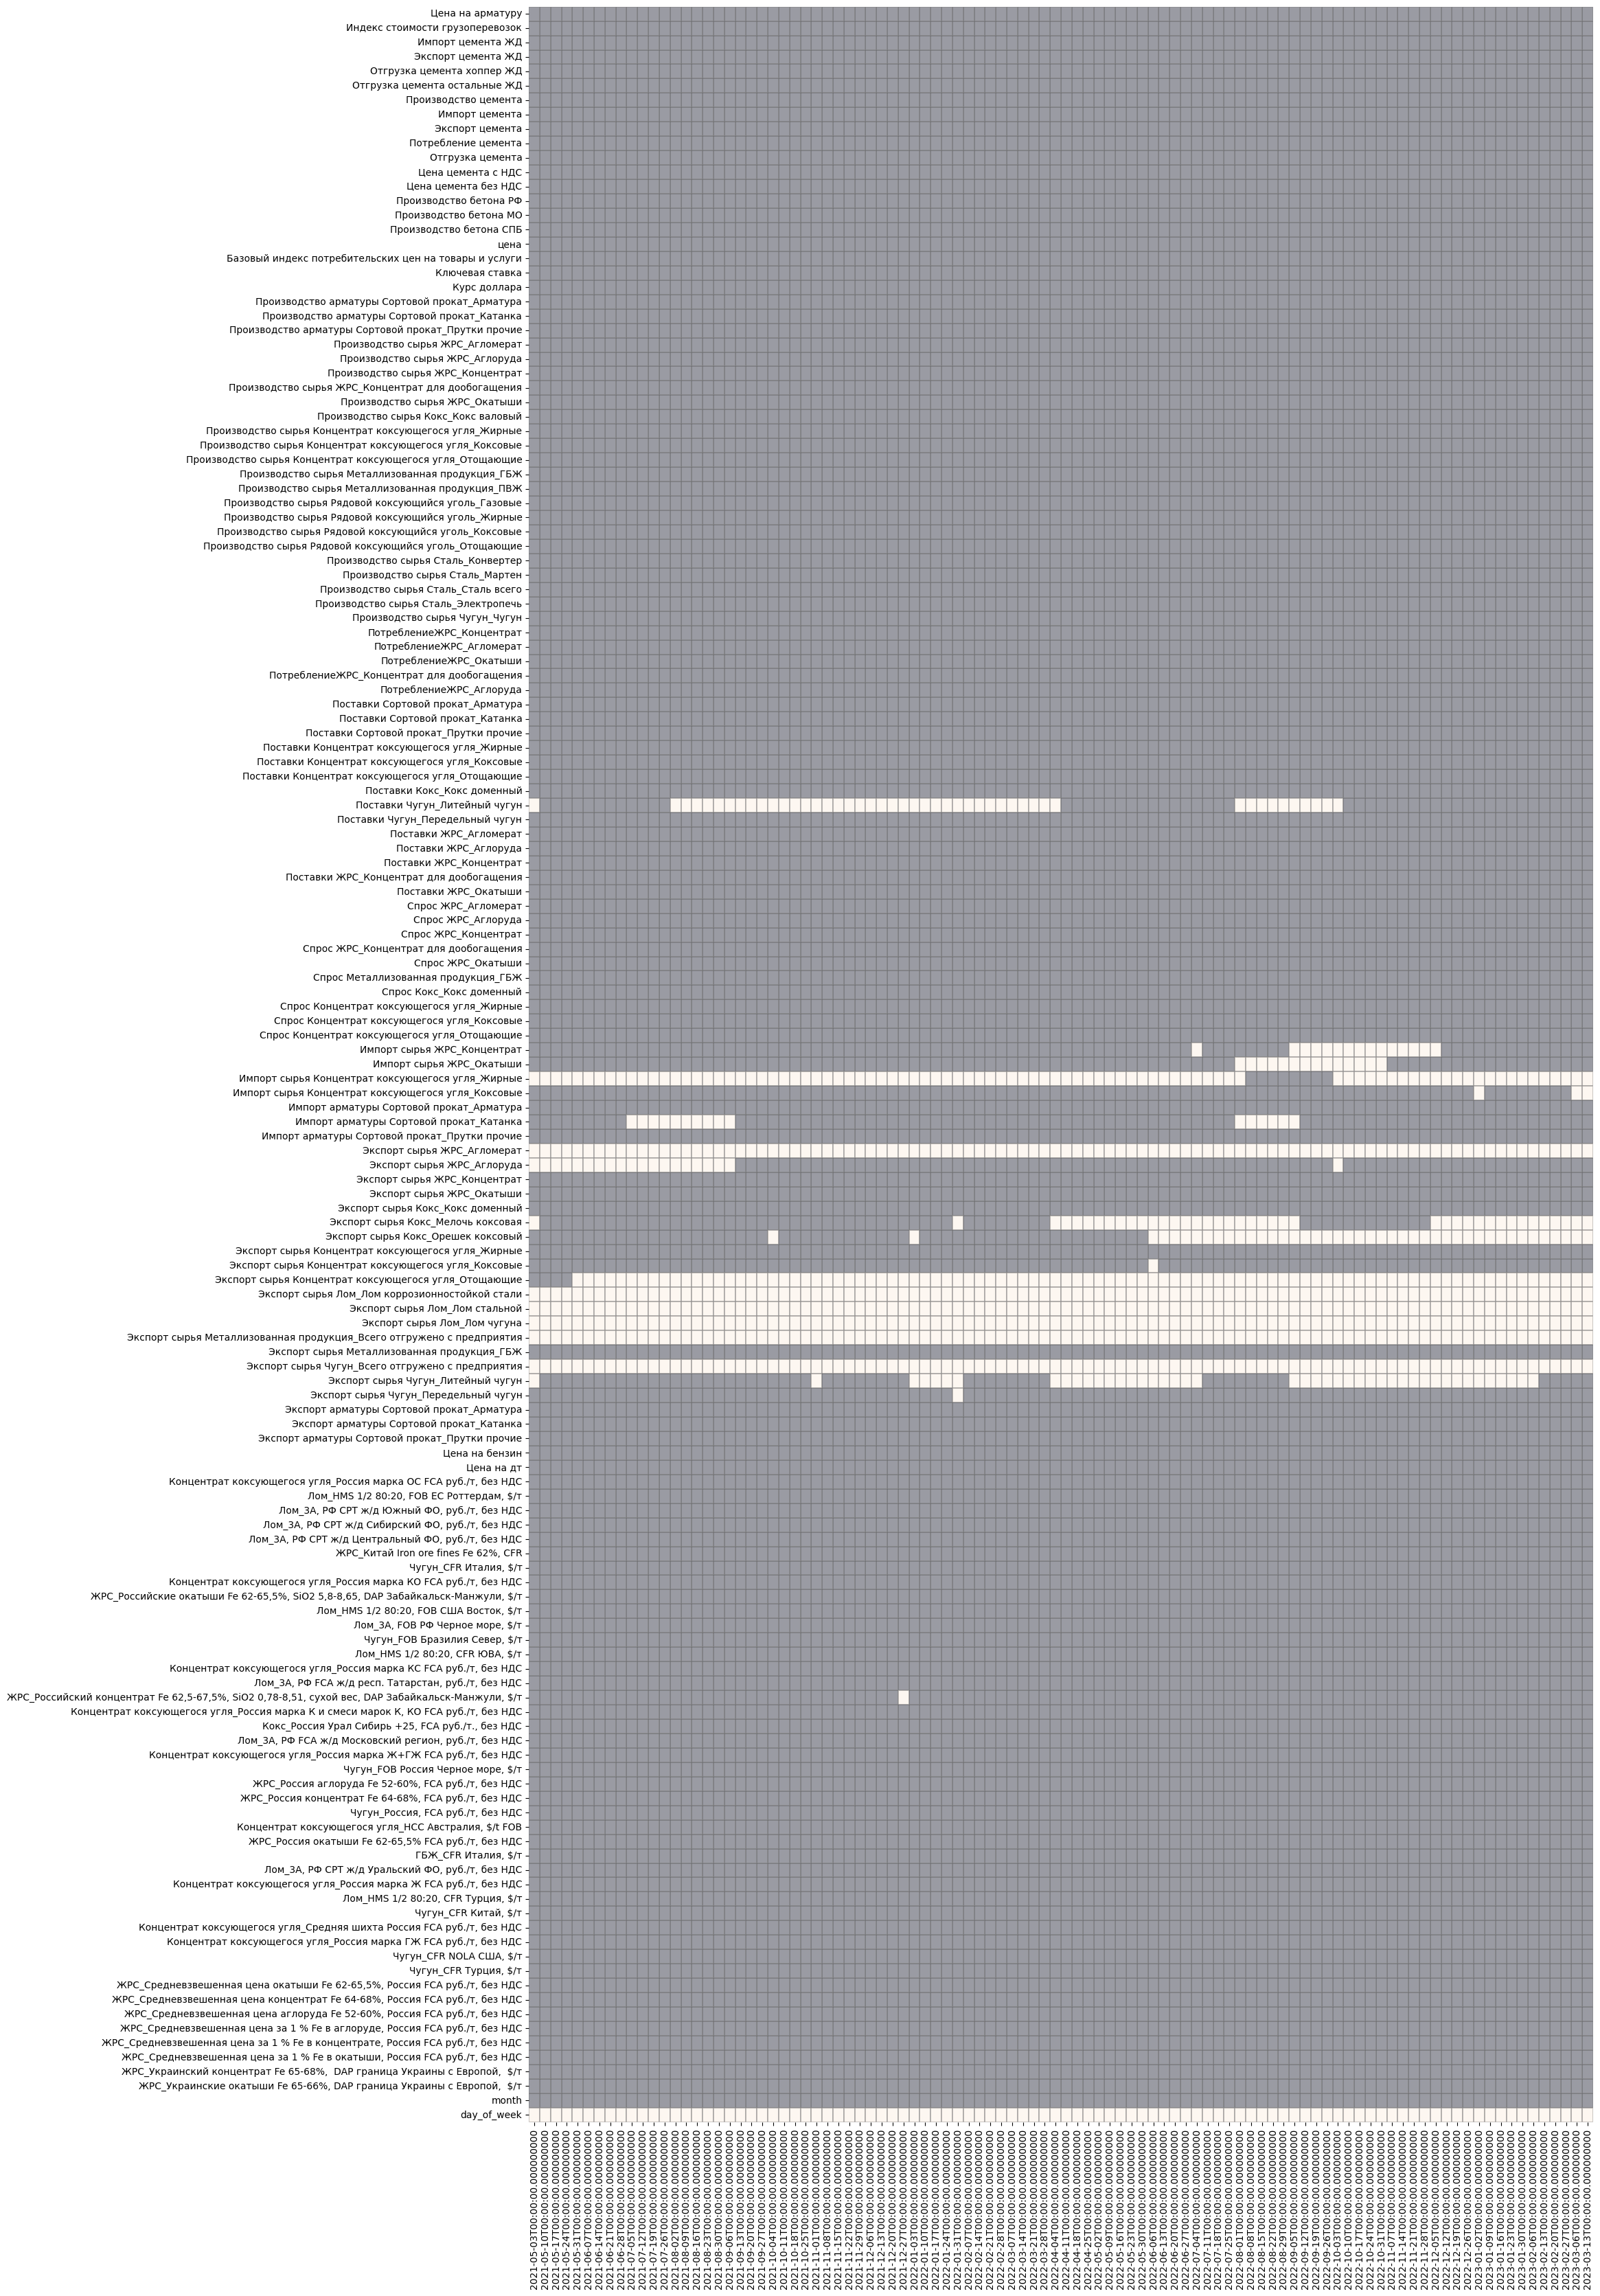

In [66]:
plt.figure(figsize=(20, 40)) 
sns.heatmap(df_cleaned.T==0, cbar=False, linewidths=0.1, linecolor='gray', alpha=0.4)
plt.show()

In [67]:
df_cleaned = df_cleaned.loc[:, (df_cleaned == 0.0).mean() <= 0.8]

In [68]:
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')

check_stationarity(df_cleaned['Цена на арматуру'])  # Проверь целевую переменную

ADF Statistic: -2.1271051502672047
p-value: 0.23375606345581695
Critical Value (1%): -3.5003788874873405
Critical Value (5%): -2.8921519665075235
Critical Value (10%): -2.5830997960069446


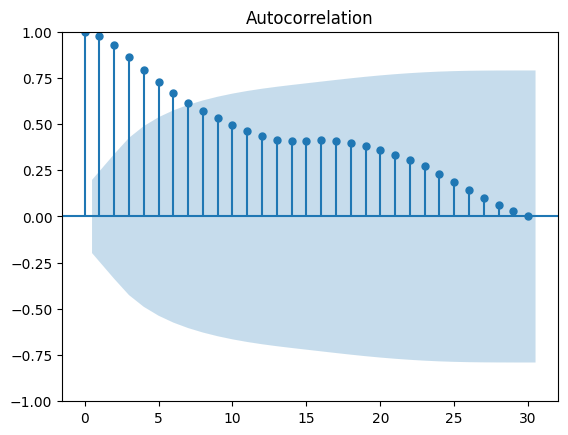

In [69]:
plot_acf(df_cleaned['Цена на арматуру'], lags=30)  # Смотрим автокорреляцию на 30 лагов
plt.show()

In [70]:
df_cleaned = df_cleaned.rename(columns={'Цена на арматуру':'price'})

df_cleaned['price_diff'] = df_cleaned['price'] - df_cleaned['price'].shift(1)
df_cleaned['price_seasonal_diff'] = df_cleaned['price'] - df_cleaned['price'].shift(12)
df_cleaned.dropna(inplace=True)  # Убираем NaN в начале

check_stationarity(df_cleaned['price_diff'])  # Тест на стационарность

ADF Statistic: -4.627431139671464
p-value: 0.0001149385896410928
Critical Value (1%): -3.5097356063504983
Critical Value (5%): -2.8961947486260944
Critical Value (10%): -2.5852576124567475


In [71]:
# xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.08, random_state=42)
# lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.08, random_state=42)

# # Создаём стекинг-регрессор
# stacking_model = StackingRegressor(
#     regressors=[
#         xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, random_state=42),
#         lgb.LGBMRegressor(n_estimators=100, learning_rate=0.08, random_state=42)], 
#         meta_regressor=Ridge(alpha=1.0), cv=5)

In [72]:
def create_lag_features(df, target_col, lags=[1, 4, 12]):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    corr_threshold = 0.05
    lag_corr = df.corr()[target_col].abs()
    useful_lags = lag_corr[lag_corr > corr_threshold].index.tolist()
    return df[useful_lags]

df = create_lag_features(df_cleaned, target_col='price', lags=[1, 4, 12])
df.fillna(df.median(), inplace=True)

C:\Users\Евгений\AppData\Local\Temp\ipykernel_21268\2311422105.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.median(), inplace=True)


In [73]:
train_size = int(len(df) * 0.8)
train_mod, test_mod = df.iloc[:train_size], df.iloc[train_size:]

In [74]:
X_train, y_train = train_mod.drop(columns=['price']), train_mod['price']
X_test, y_test = test_mod.drop(columns=['price']), test_mod['price']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(68, 136) (68,)
(18, 136) (18,)


In [75]:
# Переименовываем столбцы, чтобы избежать проблем с JSON-символами
X_train.columns = X_train.columns.str.replace(r'\W+', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'\W+', '_', regex=True)

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
lgb_model = lgb.LGBMRegressor(
    num_leaves=31,
    # min_data_in_leaf=5,
    max_depth=6,
    n_estimators=200,
    learning_rate=0.01,
    random_state=42
)

In [78]:
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=3,
    random_state=42
)

In [79]:

xgb_model.fit(X_train_scaled, y_train)

lgb_model.fit(X_train_scaled, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2863
[LightGBM] [Info] Number of data points in the train set: 68, number of used features: 136
[LightGBM] [Info] Start training from score 57902.941176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LGBMRegressor(learning_rate=0.01, max_depth=6, n_estimators=200,
              random_state=42)

Функция для вывода наиболее важных признаков в файле

In [80]:
def get_feature_importance_df(model, feature_names, model_name):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)

    plt.figure(figsize=(40, 20))
    plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx])
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title(f"Feature Importance - {model_name}")
    plt.show()
    return pd.DataFrame({'Feature': feature_names, f'{model_name}_Importance': importance})

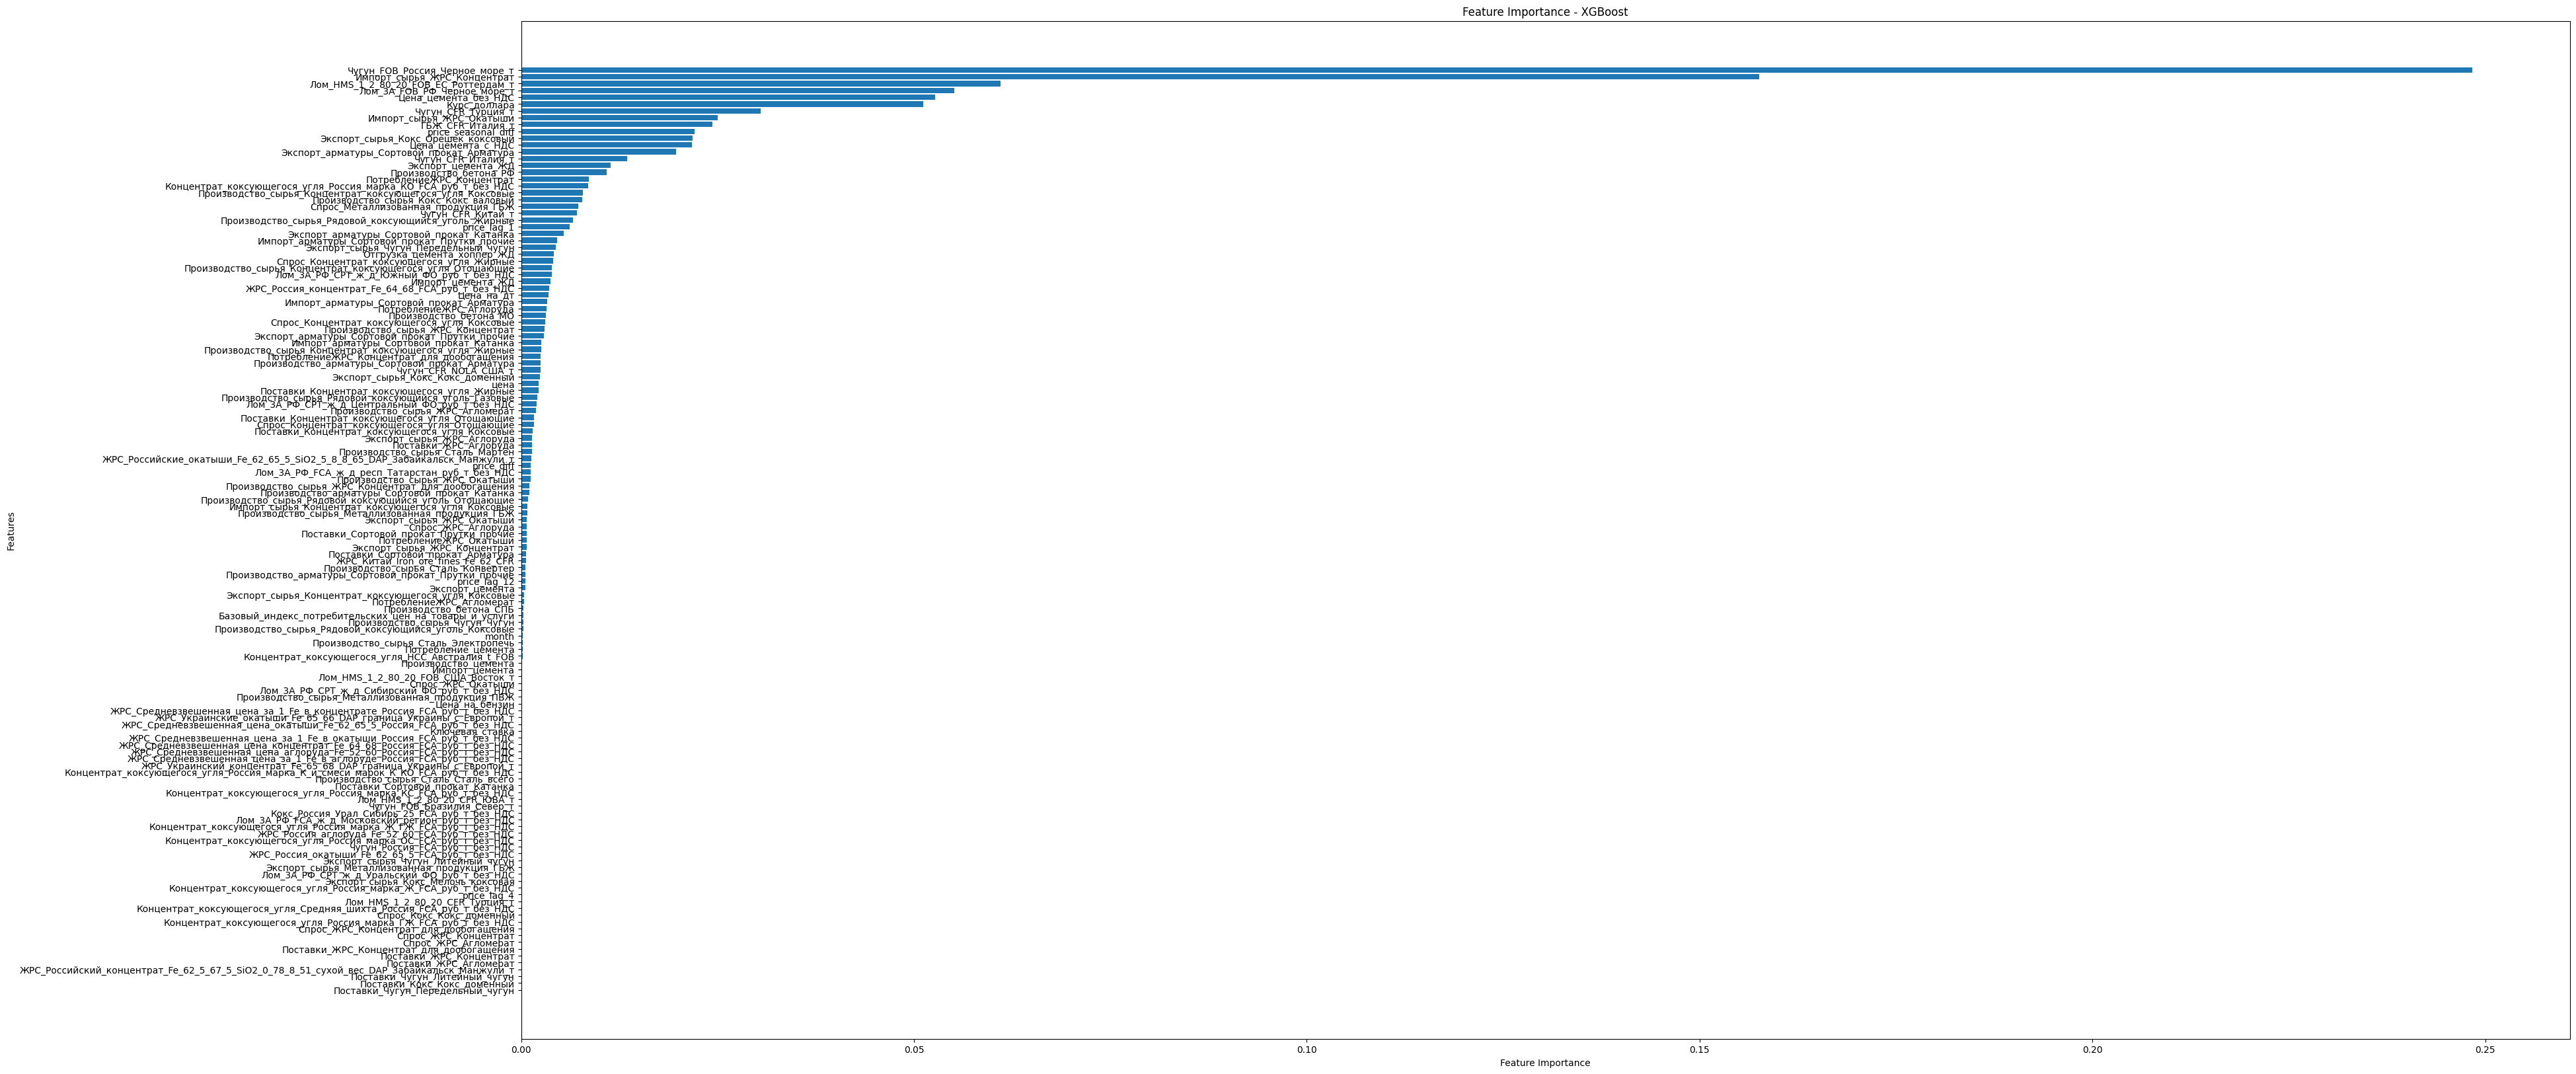

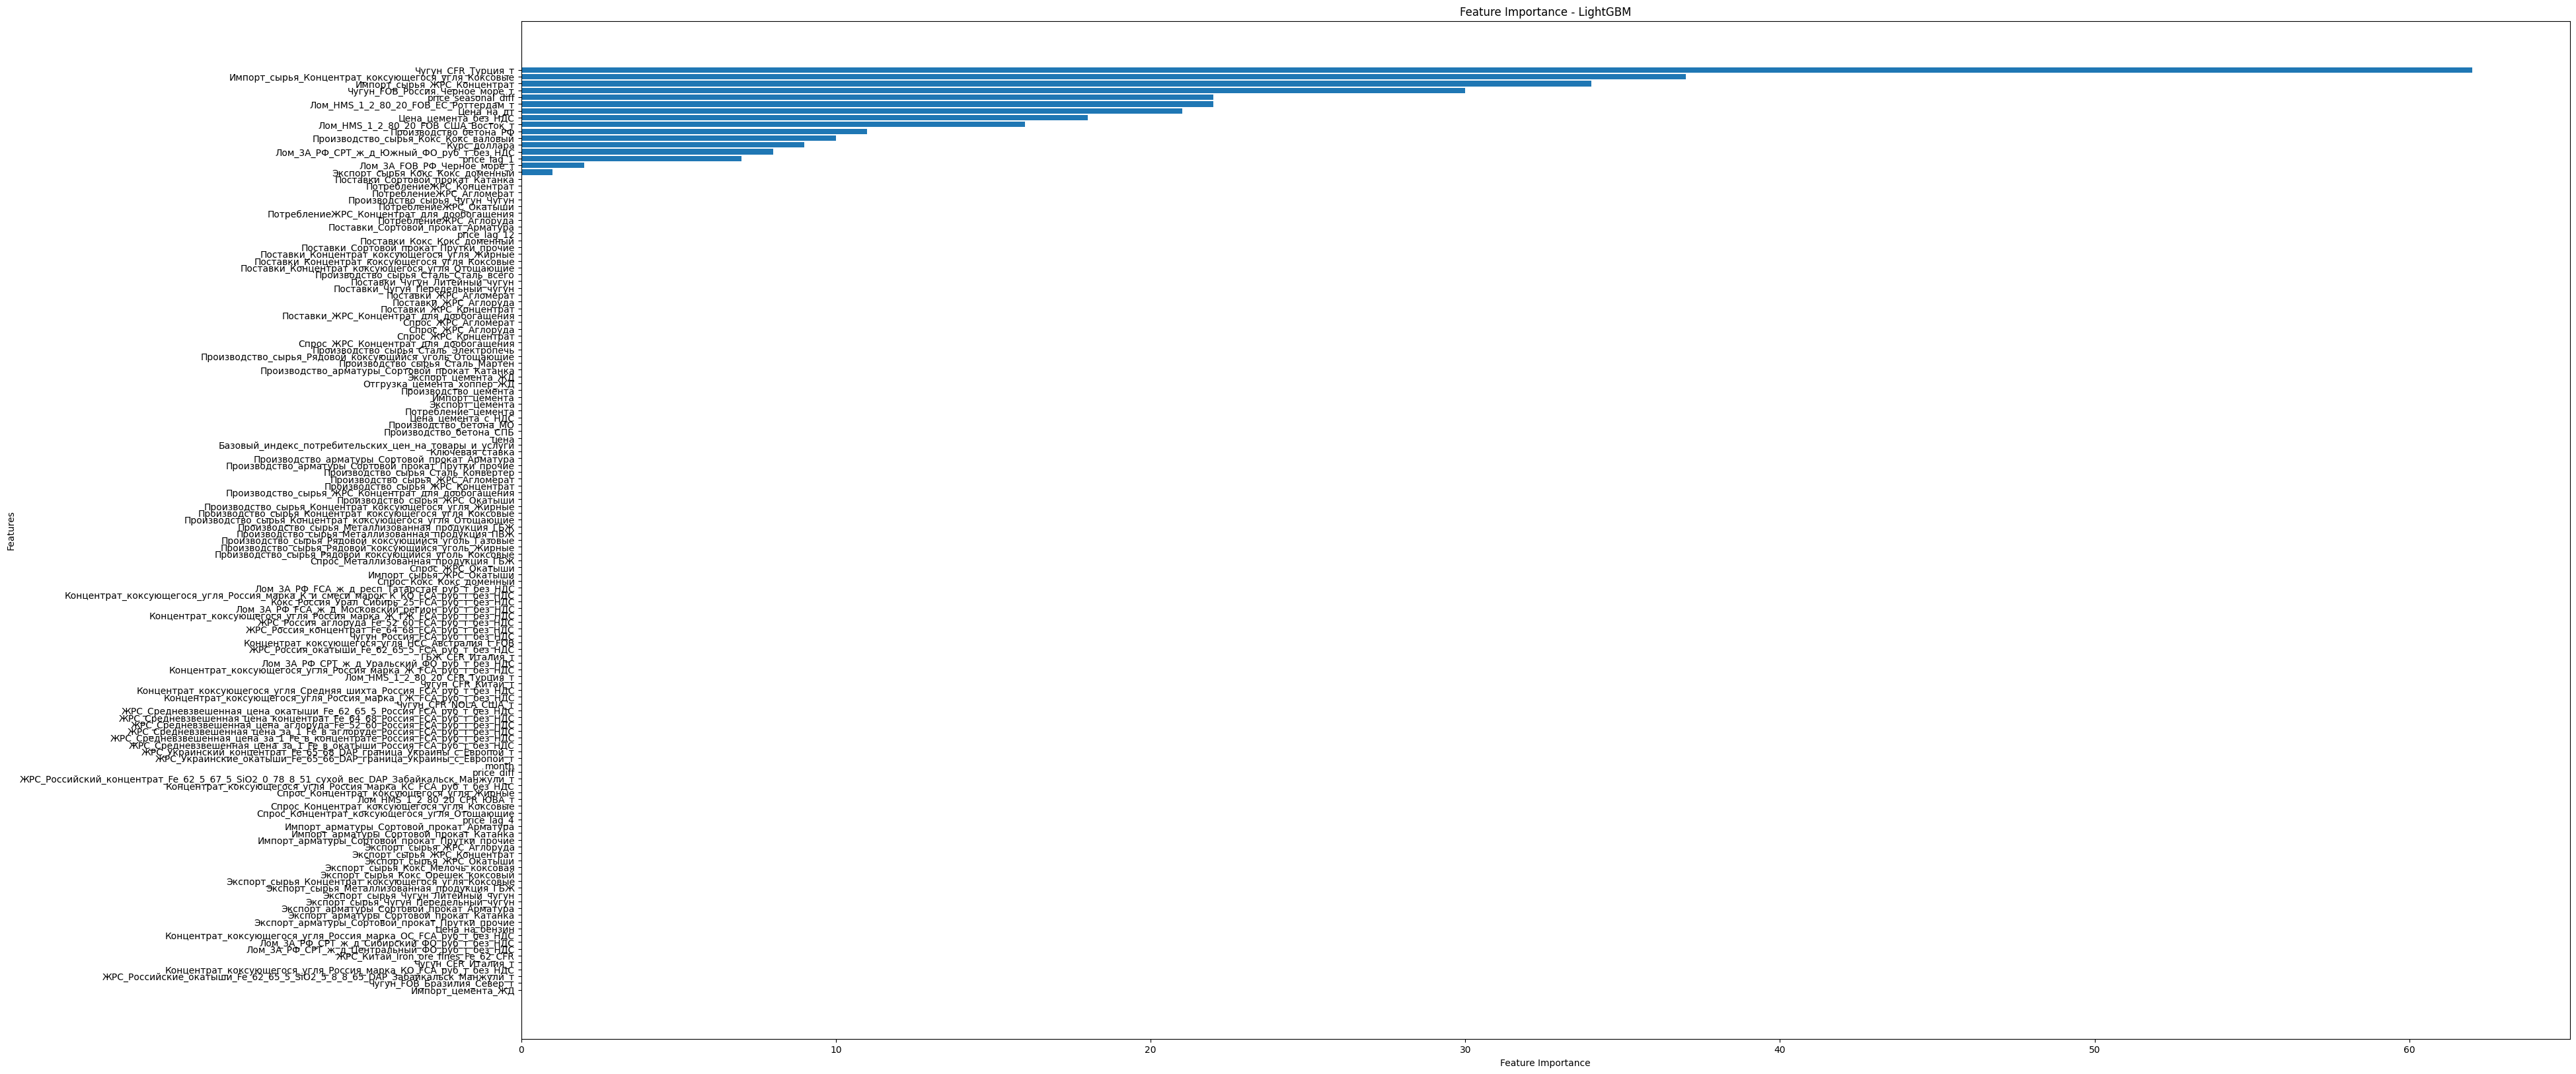

In [81]:
xgb_importance = get_feature_importance_df(xgb_model, X_train.columns, "XGBoost")
lgb_importance = get_feature_importance_df(lgb_model, X_train.columns, "LightGBM")

importance_df = pd.merge(lgb_importance, xgb_importance, on='Feature', how='outer').fillna(0)

In [82]:
# Добавляем среднюю важность
importance_df['Average_Importance'] = (importance_df['LightGBM_Importance'] + importance_df['XGBoost_Importance']) / 2
importance_df.describe()

LightGBM_Importance  XGBoost_Importance  Average_Importance
count           136.000000          136.000000          136.000000
mean              2.279412            0.007353            1.143382
std               8.151974            0.026736            4.083338
min               0.000000            0.000000            0.000000
25%               0.000000            0.000000            0.000000
50%               0.000000            0.000702            0.000354
75%               0.000000            0.003339            0.001968
max              62.000000            0.248356           31.015244

In [83]:
print(importance_df['Average_Importance'].describe().quantile(0.25))

0.0002655647440406028


In [84]:

# Фильтрация: признаки с нулевой важностью в обеих моделях
# zero_importance = importance_df[(importance_df['LightGBM_Importance'] < 3) & 
#                                 (importance_df['XGBoost_Importance'] < 0.000022)]
zero_importance = importance_df[(importance_df['Average_Importance'] < 1.500004)]
len(zero_importance)

122

In [85]:
# Удаление нулевых признаков из тренировочных и тестовых данных
X_train_filtered = X_train.drop(columns=zero_importance['Feature'].values)
X_test_filtered = X_test.drop(columns=zero_importance['Feature'].values)

print(f"Удалено {len(zero_importance)} признаков, оставлено {X_train_filtered.shape[1]} признаков.")

Удалено 122 признаков, оставлено 14 признаков.


In [86]:
X_train_filtered.shape

(68, 14)

In [87]:
y_train.shape

(68,)

In [88]:
# Добавляем CatBoost
catboost_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.01,
    depth=4,
    random_state=42,
    verbose=0  # Отключаем вывод логов
)

In [89]:
# Создаём стекинг-регрессор
stacking_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('catboost', catboost_model)  
    ],
    final_estimator=ElasticNet(alpha=0.5, l1_ratio=0.7, random_state=42),  # ElasticNet
    cv=4
)

In [90]:
stacking_model.fit(X_train_filtered, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 68, number of used features: 14
[LightGBM] [Info] Start training from score 57902.941176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

StackingRegressor(cv=4,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=0.1,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_cons...
                                            max_leaves=None, min_child_weight=3,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('lgb',
                               LGBMRegressor(learning_rate=0.01, max_depth=6,
                                             n_estimators=200,
                                             random_state=42)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x0000026DB2C0E850>)],
                  final_estimator=ElasticNet(alpha=0.5, l1_ratio=0.7,
                                             random_state=42))

In [91]:
y_pred = stacking_model.predict(X_test_filtered)

print('-----------------------------------------------------------------------------------------------------------------------------------------')
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

print('-----------------------------------------------------------------------------------------------------------------------------------------')
r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2}")

-----------------------------------------------------------------------------------------------------------------------------------------
MAE: 1606.566136783253
-----------------------------------------------------------------------------------------------------------------------------------------
R^2: 0.792470978498896


<Axes: >

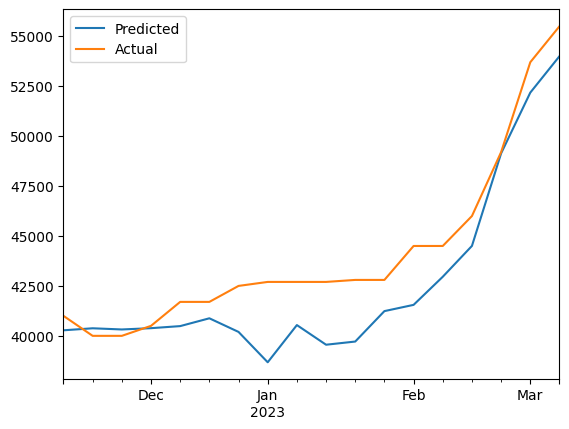

In [92]:
pres_test_data = pd.DataFrame(y_pred, index=y_test.index, columns=['Predicted'])
pres_test_data['Actual'] = y_test
pres_test_data.plot()